# Self-Attention

- Self-attention allows a model to weigh **the importance of different words in a sequence relative to each other**.

- For each word, it calculates **attention scores with every other word, allowing the model to capture relationships regardless of their distance in the sequence**.


## Key Steps

1. Transform input embeddings into queries, keys, and values
2. Calculate attention scores between queries and keys
3. Scale and normalize these scores with softmax
4. Use these attention weights to create weighted combinations of values

1. Prepare your input data: The first step is to prepare your input data, usually a sequence of data such as text or a time series.

2. Calculate attention scores: The next step is calculating the attention scores between each element in the input sequence. This is done by applying a multi-layer feedforward neural network to each aspect, generating a set of attention scores representing each element’s importance in the series.

3. Apply attention mechanism: Using the attention scores, the attention mechanism can be applied to the input sequence. This is done by weighting each element in the series by its attention score, producing a weighted representation of the input sequence.

4. Pass the weighted representation through the model: The weighted term of the input sequence is then passed through the rest of the model, typically a series of fully connected layers, to make predictions.

5. Train the model: Finally, the model is trained using a supervised learning algorithm, like cross-entropy loss, to minimise the prediction error.

# Multi-Head Attention

1. Splitting the embedding dimension into multiple "heads"
2. Running parallel attention operations in each head
3. Allowing each head to focus on different aspects of the relationships
4. Concatenating and transforming the results

In [1]:
import numpy as np
import torch
import torch.nn as nn #Netural network
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
class SelfAttention(nn.Module):
    def __init__(self, embed_size, heads):
        """
        Self Attention mechanism

        Args:
            embed_size: Embedding dimension
            heads: Number of attention heads
        """
        super(SelfAttention, self).__init__()
        self.embed_size = embed_size
        self.heads = heads
        self.head_dim = embed_size // heads

        assert self.head_dim * heads == embed_size, "Embedding size needs to be divisible by heads"

        # Linear layers for queries, keys, and values
        self.q = nn.Linear(self.head_dim, self.head_dim, bias=False)
        self.k = nn.Linear(self.head_dim, self.head_dim, bias=False)
        self.v = nn.Linear(self.head_dim, self.head_dim, bias=False)

        # Output linear layer
        self.fc_out = nn.Linear(heads * self.head_dim, embed_size)

    def forward(self, query, key, value, mask=None):
        # Get batch size and sequence length
        N = query.shape[0]
        query_len, key_len, value_len = query.shape[1], key.shape[1], value.shape[1]

        # Reshape for multi-head attention
        # Original: [N, seq_len, embed_size] -> [N, seq_len, heads, head_dim]
        query = query.reshape(N, query_len, self.heads, self.head_dim)
        key = key.reshape(N, key_len, self.heads, self.head_dim)
        value = value.reshape(N, value_len, self.heads, self.head_dim)

        # Apply linear transformations
        query = self.q(query)  # (N, query_len, heads, head_dim)
        key = self.k(key)      # (N, key_len, heads, head_dim)
        value = self.v(value)  # (N, value_len, heads, head_dim)

        # Compute attention scores
        # Transpose key for matrix multiplication
        # (N, heads, query_len, head_dim) x (N, heads, head_dim, key_len) -> (N, heads, query_len, key_len)
        energy = torch.einsum("nqhd,nkhd->nhqk", [query, key])

        # Scale the attention scores
        energy = energy / (self.head_dim ** 0.5)

        # Apply mask if provided (used in decoder for causal attention)
        if mask is not None:
            energy = energy.masked_fill(mask == 0, float("-1e20"))

        # Apply softmax to get attention weights
        attention = F.softmax(energy, dim=-1)  # (N, heads, query_len, key_len)

        # Multiply attention weights with values
        # (N, heads, query_len, key_len) x (N, heads, value_len, head_dim) -> (N, heads, query_len, head_dim)
        out = torch.einsum("nhql,nlhd->nqhd", [attention, value])

        # Reshape and pass through final linear layer
        out = out.reshape(N, query_len, self.heads * self.head_dim)  # (N, query_len, embed_size)
        out = self.fc_out(out)  # (N, query_len, embed_size)

        return out, attention


In [3]:
class MultiHeadAttention(nn.Module):
    def __init__(self, embed_size, heads):
        """
        Multi-Head Attention mechanism (more standard implementation)

        Args:
            embed_size: Embedding dimension
            heads: Number of attention heads
        """
        super(MultiHeadAttention, self).__init__()
        self.embed_size = embed_size
        self.heads = heads
        self.head_dim = embed_size // heads

        assert self.head_dim * heads == embed_size, "Embedding size needs to be divisible by heads"

        # Single linear layers for all heads
        self.query = nn.Linear(embed_size, embed_size)
        self.key = nn.Linear(embed_size, embed_size)
        self.value = nn.Linear(embed_size, embed_size)

        # Output linear layer
        self.fc_out = nn.Linear(embed_size, embed_size)

    def forward(self, query, key, value, mask=None):
        N = query.shape[0]
        query_len, key_len, value_len = query.shape[1], key.shape[1], value.shape[1]

        # Apply linear transformations first
        query = self.query(query)  # (N, query_len, embed_size)
        key = self.key(key)        # (N, key_len, embed_size)
        value = self.value(value)  # (N, value_len, embed_size)

        # Reshape for multiple heads
        query = query.reshape(N, query_len, self.heads, self.head_dim)
        key = key.reshape(N, key_len, self.heads, self.head_dim)
        value = value.reshape(N, value_len, self.heads, self.head_dim)

        # Compute attention scores
        energy = torch.einsum("nqhd,nkhd->nhqk", [query, key])

        # Scale the attention scores
        energy = energy / (self.head_dim ** 0.5)

        # Apply mask if provided
        if mask is not None:
            energy = energy.masked_fill(mask == 0, float("-1e20"))

        # Apply softmax to get attention weights
        attention = F.softmax(energy, dim=-1)  # (N, heads, query_len, key_len)
        # Store the attention weights for visualization
        self.attention_weights = attention.detach()

        # Multiply attention weights with values
        out = torch.einsum("nhql,nlhd->nqhd", [attention, value])

        # Reshape and pass through final linear layer
        out = out.reshape(N, query_len, self.heads * self.head_dim)
        out = self.fc_out(out)

        return out

In [5]:
# Real-time example with sentence processing
def process_sentence_with_attention():
    # Sample sentence
    sentence = "The cat sat on the mat"
    words = sentence.lower().split()

    # Simple word embedding (for demonstration)
    # In real applications, you would use pre-trained embeddings like Word2Vec or GloVe
    word_to_idx = {word: i for i, word in enumerate(set(words))}
    vocab_size = len(word_to_idx)

    # Create a simple embedding matrix (random for demonstration)
    np.random.seed(42)  # For reproducibility
    embed_dim = 8
    embedding_matrix = np.random.randn(vocab_size, embed_dim)

    # Convert words to embeddings
    word_indices = [word_to_idx[word] for word in words]
    word_embeddings = np.array([embedding_matrix[idx] for idx in word_indices])

    # Convert to PyTorch tensors
    embeddings = torch.tensor(word_embeddings, dtype=torch.float32).unsqueeze(0)  # Add batch dimension

    # Initialize attention mechanisms
    embed_size = embed_dim
    heads = 2
    self_attention = SelfAttention(embed_size, heads)

    # Process through self-attention
    with torch.no_grad():
        output, attention_weights = self_attention(embeddings, embeddings, embeddings)

    print(f"Input sentence: {sentence}")
    print(f"Input shape: {embeddings.shape}")
    print(f"Output shape: {output.shape}")

    # Visualize attention weights
    plt.figure(figsize=(10, 5))

    for h in range(heads):
        plt.subplot(1, heads, h+1)
        attn = attention_weights[0, h].numpy()
        sns.heatmap(attn, annot=True, cmap='viridis', xticklabels=words, yticklabels=words)
        plt.title(f'Head {h+1} Attention')

    plt.tight_layout()
    plt.show()

    return {
        'words': words,
        'attention_weights': attention_weights,
        'output': output
    }


In [6]:
# Real-world application example: Sentiment analysis with attention
class AttentionSentimentClassifier(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, num_classes, num_heads):
        super(AttentionSentimentClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.attention = MultiHeadAttention(embed_size, num_heads)
        self.fc = nn.Linear(embed_size, hidden_size)
        self.classifier = nn.Linear(hidden_size, num_classes)
        self.dropout = nn.Dropout(0.1)

    def forward(self, x):
        # x shape: (batch_size, seq_len)
        embedded = self.embedding(x)  # (batch_size, seq_len, embed_size)

        # Self-attention
        attended = self.attention(embedded, embedded, embedded)  # (batch_size, seq_len, embed_size)

        # Global average pooling over sequence length
        pooled = torch.mean(attended, dim=1)  # (batch_size, embed_size)

        # Fully connected layers
        hidden = F.relu(self.fc(pooled))
        hidden = self.dropout(hidden)
        output = self.classifier(hidden)

        return output

In [7]:
# Example of how to train the sentiment classifier
def sentiment_analysis_example():
    # This is a simplified example - in a real scenario you would use actual data

    # Sample parameters
    vocab_size = 5000
    embed_size = 128
    hidden_size = 64
    num_classes = 2  # Binary sentiment (positive/negative)
    num_heads = 4

    # Initialize model
    model = AttentionSentimentClassifier(vocab_size, embed_size, hidden_size, num_classes, num_heads)

    # Sample input (batch of 3 sentences, each with max length of 10)
    input_ids = torch.randint(0, vocab_size, (3, 10))

    # Forward pass
    outputs = model(input_ids)

    print(f"Sentiment logits shape: {outputs.shape}")
    print(f"Sample sentiment logits: {outputs}")

    # In a real scenario, you would:
    # 1. Prepare your dataset with tokenization and padding
    # 2. Define loss function and optimizer
    # 3. Train the model with actual labeled data
    # 4. Evaluate on validation set
    # 5. Use the model for inference on new data

    return model, outputs




Input sentence: The cat sat on the mat
Input shape: torch.Size([1, 6, 8])
Output shape: torch.Size([1, 6, 8])


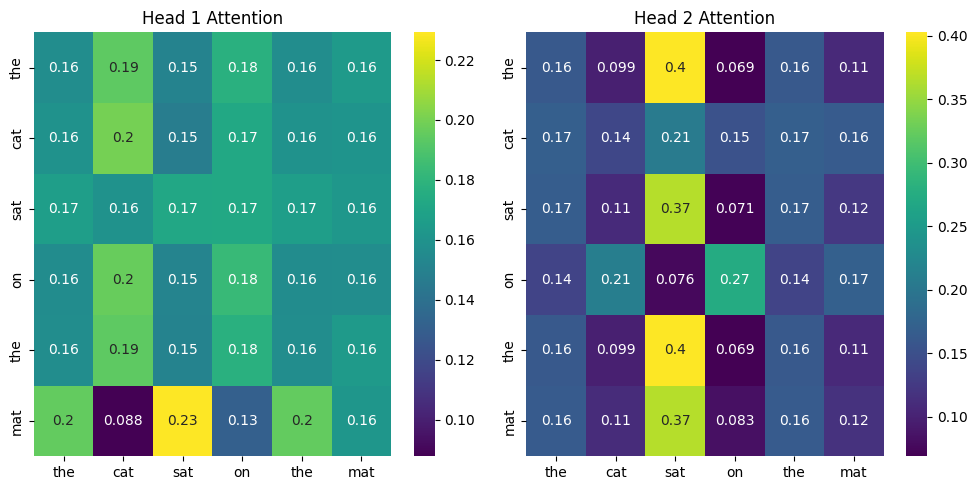

Sentiment logits shape: torch.Size([3, 2])
Sample sentiment logits: tensor([[ 0.1112, -0.0213],
        [ 0.1108, -0.0074],
        [ 0.1610, -0.0307]], grad_fn=<AddmmBackward0>)


In [8]:
if __name__ == "__main__":
    # Run the basic sentence processing example
    result = process_sentence_with_attention()

    # Run the sentiment analysis example
    model, outputs = sentiment_analysis_example()

# Self - Attention code

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [10]:
# --- 1. Define the SelfAttention Module ---
class SelfAttention(nn.Module):
    def __init__(self, embed_dim, num_heads=1):
        """
        Initializes the SelfAttention module.

        Args:
            embed_dim (int): The dimension of the input embeddings.
            num_heads (int): The number of attention heads (for simplicity, we'll stick to 1 initially,
                             but multi-head attention is just running this process in parallel and concatenating).
        """
        super().__init__()
        if embed_dim % num_heads != 0:
            raise ValueError(
                f"Embedding dimension ({embed_dim}) must be divisible by number of heads ({num_heads})"
            )
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads

        # Linear layers to project input into Query, Key, and Value matrices
        # For single-head attention, these project from embed_dim to embed_dim
        # For multi-head, they project from embed_dim to num_heads * head_dim (which is embed_dim)
        self.W_q = nn.Linear(embed_dim, embed_dim)
        self.W_k = nn.Linear(embed_dim, embed_dim)
        self.W_v = nn.Linear(embed_dim, embed_dim)

        # Output linear layer (for multi-head, this combines outputs from different heads)
        self.W_o = nn.Linear(embed_dim, embed_dim)

    def forward(self, x):
        """
        Forward pass for the SelfAttention module.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, sequence_length, embed_dim).

        Returns:
            torch.Tensor: Output tensor of shape (batch_size, sequence_length, embed_dim)
                          representing the attended features.
            torch.Tensor: Attention weights (for visualization/interpretability).
        """
        batch_size, seq_len, embed_dim = x.size()

        # 1. Project input x to Query, Key, Value using linear layers
        # Resulting shape: (batch_size, sequence_length, embed_dim)
        Q = self.W_q(x)
        K = self.W_k(x)
        V = self.W_v(x)

        # For multi-head attention, these would be reshaped and permuted:
        # Q = Q.view(batch_size, seq_len, self.num_heads, self.head_dim).permute(0, 2, 1, 3)
        # K = K.view(batch_size, seq_len, self.num_heads, self.head_dim).permute(0, 2, 1, 3)
        # V = V.view(batch_size, seq_len, self.num_heads, self.head_dim).permute(0, 2, 1, 3)
        # Then attention is applied per head, and results are concatenated.

        # 2. Calculate attention scores (dot product of Q and K transpose)
        # (batch_size, seq_len, embed_dim) @ (batch_size, embed_dim, seq_len)
        # -> (batch_size, seq_len, seq_len)
        # Q @ K.transpose(-2, -1) performs batch matrix multiplication
        attention_scores = torch.bmm(Q, K.transpose(1, 2))

        # 3. Scale the attention scores
        # This helps prevent the softmax function from having extremely small gradients
        scaling_factor = torch.sqrt(torch.tensor(self.head_dim, dtype=torch.float32))
        scaled_attention_scores = attention_scores / scaling_factor

        # 4. Apply softmax to get attention weights
        # (batch_size, seq_len, seq_len)
        # The softmax is applied over the last dimension (the Key dimension),
        # meaning for each query word, the weights sum to 1 over all key words.
        attention_weights = F.softmax(scaled_attention_scores, dim=-1)

        # 5. Multiply attention weights with Value matrix
        # (batch_size, seq_len, seq_len) @ (batch_size, seq_len, embed_dim)
        # -> (batch_size, seq_len, embed_dim)
        attended_output = torch.bmm(attention_weights, V)

        # 6. Apply final linear layer (W_o)
        # (This step is more critical for multi-head attention to combine heads,
        # but it's good practice to include it for single head as well.)
        output = self.W_o(attended_output)

        return output, attention_weights

In [11]:
# --- 2. Prepare Sample Data (Simulated Word Embeddings) ---

# Let's represent a short sentence like "The quick brown fox"
# For simplicity, we'll use small random tensors as word embeddings.
# Assume:
#   Batch size = 1 (one sentence)
#   Sequence length = 4 (4 words)
#   Embedding dimension = 64 (size of each word vector)

batch_size = 1
sequence_length = 4
embed_dim = 64

# Simulate word embeddings for a sentence.
# In a real scenario, these would come from an embedding layer (e.g., Word2Vec, GloVe, BERT embeddings).
# Example:
# Word 1: [0.1, 0.2, ..., 0.5]
# Word 2: [0.8, 0.3, ..., 0.7]
# ...
input_embeddings = torch.randn(batch_size, sequence_length, embed_dim)

print("Input Embeddings Shape:", input_embeddings.shape) # (1, 4, 64)
print("-" * 30)


Input Embeddings Shape: torch.Size([1, 4, 64])
------------------------------


In [12]:
# --- 3. Instantiate and Run the Self-Attention Model ---

# Initialize the self-attention layer
attention_layer = SelfAttention(embed_dim=embed_dim)

# Perform the forward pass
output_features, attention_weights = attention_layer(input_embeddings)

print("Output Features Shape (Attended Context):", output_features.shape) # (1, 4, 64)
print("-" * 30)

print("Attention Weights Shape:", attention_weights.shape) # (1, 4, 4)
print("Attention Weights (first batch, for word 1):")
# This shows how much each word attends to every other word in the sequence.
# For batch 0 (our only batch), for the first word (index 0):
# attention_weights[0, 0] -> weights for word 0 attending to word 0, word 1, word 2, word 3
print(attention_weights[0, 0].detach().numpy())
print("\nAttention Weights (first batch, for word 2):")
print(attention_weights[0, 1].detach().numpy())
print("-" * 30)

Output Features Shape (Attended Context): torch.Size([1, 4, 64])
------------------------------
Attention Weights Shape: torch.Size([1, 4, 4])
Attention Weights (first batch, for word 1):
[0.27993485 0.17552002 0.1874432  0.35710198]

Attention Weights (first batch, for word 2):
[0.25414947 0.28165573 0.18428047 0.27991423]
------------------------------


In [13]:

# --- 4. Interpretation of Output and Weights ---

print("Explanation of Output:")
print("The `output_features` tensor now contains new representations for each word.")
print("Each word's new representation is a weighted sum of ALL words in the sentence,")
print("where the weights (`attention_weights`) determine how much each other word contributes.")
print("This effectively means each word's representation is enriched with contextual information from the entire sequence.")
print("\nExplanation of Attention Weights:")
print("`attention_weights` has shape (batch_size, sequence_length, sequence_length).")
print("`attention_weights[b, i, j]` represents how much the i-th word in sentence `b` 'attends' to the j-th word in the same sentence.")
print("For example, `attention_weights[0, 0, 0]` is how much the first word attends to itself.")
print("`attention_weights[0, 0, 1]` is how much the first word attends to the second word.")
print("The sum of `attention_weights[b, i, :]` (across the last dimension) for any `i` is 1.")

# Example of how to interpret attention_weights for a single word's attention
# For word at index `i_query`:
# `attention_weights[0, i_query, :]` shows its attention distribution over all words.
word_index_to_examine = 0 # Let's look at the first word's attention
print(f"\nAttention distribution for word at index {word_index_to_examine}:")
print(attention_weights[0, word_index_to_examine, :].detach().numpy())

Explanation of Output:
The `output_features` tensor now contains new representations for each word.
Each word's new representation is a weighted sum of ALL words in the sentence,
where the weights (`attention_weights`) determine how much each other word contributes.
This effectively means each word's representation is enriched with contextual information from the entire sequence.

Explanation of Attention Weights:
`attention_weights` has shape (batch_size, sequence_length, sequence_length).
`attention_weights[b, i, j]` represents how much the i-th word in sentence `b` 'attends' to the j-th word in the same sentence.
For example, `attention_weights[0, 0, 0]` is how much the first word attends to itself.
`attention_weights[0, 0, 1]` is how much the first word attends to the second word.
The sum of `attention_weights[b, i, :]` (across the last dimension) for any `i` is 1.

Attention distribution for word at index 0:
[0.27993485 0.17552002 0.1874432  0.35710198]


# Another example - Self-Attention

In [14]:
import torch
import torch.nn.functional as F

def scaled_dot_product_attention(Q: torch.Tensor, K: torch.Tensor, V: torch.Tensor) -> (torch.Tensor, torch.Tensor):
    """
    Performs scaled dot-product attention.

    Args:
        Q (torch.Tensor): Query tensor, shape (..., seq_len_q, embed_dim)
        K (torch.Tensor): Key tensor, shape (..., seq_len_k, embed_dim)
        V (torch.Tensor): Value tensor, shape (..., seq_len_k, embed_dim)

    Returns:
        tuple: A tuple containing:
            - attended_output (torch.Tensor): The contextualized output, shape (..., seq_len_q, embed_dim)
            - attention_weights (torch.Tensor): The attention weights, shape (..., seq_len_q, seq_len_k)
    """
    # Get the dimension of the keys for scaling
    d_k = K.size(-1) # embed_dim or head_dim

    # 1. Calculate attention scores (Q dot K_transpose)
    # (..., seq_len_q, embed_dim) @ (..., embed_dim, seq_len_k)
    # -> (..., seq_len_q, seq_len_k)
    attention_scores = torch.matmul(Q, K.transpose(-2, -1))

    # 2. Scale the attention scores
    scaled_attention_scores = attention_scores / (d_k ** 0.5) # Equivalent to torch.sqrt(torch.tensor(d_k, dtype=torch.float32))

    # 3. Apply softmax to get attention weights
    attention_weights = F.softmax(scaled_attention_scores, dim=-1)

    # 4. Multiply attention weights with Value matrix
    # (..., seq_len_q, seq_len_k) @ (..., seq_len_k, embed_dim)
    # -> (..., seq_len_q, embed_dim)
    attended_output = torch.matmul(attention_weights, V)

    return attended_output, attention_weights

# --- Sample Usage ---
if __name__ == "__main__":
    # --- 1. Define parameters for our example ---
    batch_size = 1
    sequence_length = 4  # Number of tokens/words in the sequence
    embed_dim = 64       # Dimension of each token's embedding

    # --- 2. Create dummy Q, K, V tensors ---
    # In a real scenario, these would come from linear projections of input embeddings.
    # For self-attention, Q, K, V typically come from the same source.
    Q = torch.randn(batch_size, sequence_length, embed_dim)
    K = torch.randn(batch_size, sequence_length, embed_dim)
    V = torch.randn(batch_size, sequence_length, embed_dim)

    print("Input Q shape:", Q.shape)
    print("Input K shape:", K.shape)
    print("Input V shape:", V.shape)
    print("-" * 30)

    # --- 3. Call the simplified attention function ---
    output_features, attention_weights = scaled_dot_product_attention(Q, K, V)

    print("Output Features Shape (Contextualized):", output_features.shape) # (1, 4, 64)
    print("Attention Weights Shape:", attention_weights.shape)       # (1, 4, 4)
    print("-" * 30)

    print("Sample Attention Weights (for the first word):")
    # This shows how much the first query word attends to each of the key words.
    print(attention_weights[0, 0, :].detach().numpy())
    print("\nSum of attention weights for the first query word (should be ~1):")
    print(attention_weights[0, 0, :].sum().item())

    print("\nExplanation:")
    print("Each row in `attention_weights` (e.g., `attention_weights[0, 0, :]`) shows how much")
    print("a specific query (e.g., the first word's query) attends to all keys (all words).")
    print("The `output_features` tensor contains new representations for each word,")
    print("enriched by a weighted sum of the `V` vectors, where the weights are from attention.")

Input Q shape: torch.Size([1, 4, 64])
Input K shape: torch.Size([1, 4, 64])
Input V shape: torch.Size([1, 4, 64])
------------------------------
Output Features Shape (Contextualized): torch.Size([1, 4, 64])
Attention Weights Shape: torch.Size([1, 4, 4])
------------------------------
Sample Attention Weights (for the first word):
[0.2732     0.3161912  0.0863199  0.32428893]

Sum of attention weights for the first query word (should be ~1):
1.0000001192092896

Explanation:
Each row in `attention_weights` (e.g., `attention_weights[0, 0, :]`) shows how much
a specific query (e.g., the first word's query) attends to all keys (all words).
The `output_features` tensor contains new representations for each word,
enriched by a weighted sum of the `V` vectors, where the weights are from attention.


# Multi-head aatention - sample code

In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [16]:
# --- Helper Function: Scaled Dot-Product Attention ---
def scaled_dot_product_attention(Q: torch.Tensor, K: torch.Tensor, V: torch.Tensor, mask: torch.Tensor = None) -> (torch.Tensor, torch.Tensor):
    """
    Performs scaled dot-product attention.

    Args:
        Q (torch.Tensor): Query tensor, shape (..., seq_len_q, embed_dim)
        K (torch.Tensor): Key tensor, shape (..., seq_len_k, embed_dim)
        V (torch.Tensor): Value tensor, shape (..., seq_len_k, embed_dim)
        mask (torch.Tensor, optional): Optional mask tensor, shape (..., seq_len_q, seq_len_k)
                                       used to mask out attention to certain positions (e.g., for padding or causality).

    Returns:
        tuple: A tuple containing:
            - attended_output (torch.Tensor): The contextualized output, shape (..., seq_len_q, embed_dim)
            - attention_weights (torch.Tensor): The attention weights, shape (..., seq_len_q, seq_len_k)
    """
    d_k = K.size(-1) # embed_dim or head_dim

    # 1. Calculate attention scores (Q dot K_transpose)
    # (..., seq_len_q, embed_dim) @ (..., embed_dim, seq_len_k)
    # -> (..., seq_len_q, seq_len_k)
    attention_scores = torch.matmul(Q, K.transpose(-2, -1))

    # 2. Scale the attention scores
    scaled_attention_scores = attention_scores / (d_k ** 0.5)

    # 3. Apply mask if provided
    if mask is not None:
        # For masked positions, set scores to a very small negative number
        # so that they become 0 after softmax.
        scaled_attention_scores = scaled_attention_scores.masked_fill(mask == 0, float('-inf'))

    # 4. Apply softmax to get attention weights
    attention_weights = F.softmax(scaled_attention_scores, dim=-1)

    # 5. Multiply attention weights with Value matrix
    # (..., seq_len_q, seq_len_k) @ (..., seq_len_k, embed_dim)
    # -> (..., seq_len_q, embed_dim)
    attended_output = torch.matmul(attention_weights, V)

    return attended_output, attention_weights


In [17]:
# --- MultiHeadAttention Module ---
class MultiHeadAttention(nn.Module):
    def __init__(self, embed_dim: int, num_heads: int):
        """
        Initializes the MultiHeadAttention module.

        Args:
            embed_dim (int): The dimension of the input embeddings (e.g., 512).
            num_heads (int): The number of attention heads (e.g., 8).
                             embed_dim must be divisible by num_heads.
        """
        super().__init__()
        if embed_dim % num_heads != 0:
            raise ValueError(
                f"Embedding dimension ({embed_dim}) must be divisible by number of heads ({num_heads})"
            )

        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads # Dimension of Q, K, V for each head

        # Linear layers for projecting input to Query, Key, Value for all heads
        # We project to (embed_dim) and then split into (num_heads, head_dim)
        self.W_q = nn.Linear(embed_dim, embed_dim)
        self.W_k = nn.Linear(embed_dim, embed_dim)
        self.W_v = nn.Linear(embed_dim, embed_dim)

        # Final linear layer to combine outputs from all heads
        self.W_o = nn.Linear(embed_dim, embed_dim)

    def forward(self, query: torch.Tensor, key: torch.Tensor, value: torch.Tensor, mask: torch.Tensor = None) -> torch.Tensor:
        """
        Forward pass for MultiHeadAttention.

        Args:
            query (torch.Tensor): Query tensor, shape (batch_size, seq_len_q, embed_dim)
            key (torch.Tensor): Key tensor, shape (batch_size, seq_len_k, embed_dim)
            value (torch.Tensor): Value tensor, shape (batch_size, seq_len_k, embed_dim)
            mask (torch.Tensor, optional): Mask tensor, shape (batch_size, seq_len_q, seq_len_k) or (1, seq_len_q, seq_len_k)

        Returns:
            torch.Tensor: Output tensor after multi-head attention, shape (batch_size, seq_len_q, embed_dim)
        """
        batch_size = query.size(0)
        seq_len_q = query.size(1)
        seq_len_k = key.size(1)

        # 1. Project Q, K, V using linear layers
        # Shape after projection: (batch_size, seq_len, embed_dim)
        Q = self.W_q(query)
        K = self.W_k(key)
        V = self.W_v(value)

        # 2. Reshape and permute for multi-head attention
        # Split the embed_dim into num_heads * head_dim and transpose for batching heads.
        # Original shape: (batch_size, seq_len, embed_dim)
        # Reshape to:     (batch_size, seq_len, num_heads, head_dim)
        # Permute to:     (batch_size, num_heads, seq_len, head_dim)
        Q = Q.view(batch_size, seq_len_q, self.num_heads, self.head_dim).transpose(1, 2)
        K = K.view(batch_size, seq_len_k, self.num_heads, self.head_dim).transpose(1, 2)
        V = V.view(batch_size, seq_len_k, self.num_heads, self.head_dim).transpose(1, 2)

        # If a mask is provided, it needs to be expanded for the head dimension
        if mask is not None:
            # Mask shape: (batch_size, seq_len_q, seq_len_k) or (1, seq_len_q, seq_len_k)
            # Expand to:  (batch_size, 1, seq_len_q, seq_len_k) for broadcasting across heads
            mask = mask.unsqueeze(1) # Add head dimension for broadcasting

        # 3. Apply scaled dot-product attention to each head
        # Resulting shape: (batch_size, num_heads, seq_len_q, head_dim)
        # And attention_weights_per_head: (batch_size, num_heads, seq_len_q, seq_len_k)
        attended_heads, attention_weights_per_head = scaled_dot_product_attention(Q, K, V, mask=mask)

        # 4. Concatenate outputs from all heads
        # Transpose back to (batch_size, seq_len_q, num_heads, head_dim)
        # Then reshape (flatten num_heads and head_dim) to (batch_size, seq_len_q, embed_dim)
        concat_heads = attended_heads.transpose(1, 2).contiguous().view(batch_size, seq_len_q, self.embed_dim)

        # 5. Apply final linear layer
        output = self.W_o(concat_heads)

        return output, attention_weights_per_head


In [18]:

# --- Sample Usage ---
if __name__ == "__main__":
    # --- Define parameters for our example ---
    batch_size = 2        # Number of sentences in a batch
    seq_len = 5           # Sequence length (e.g., 5 words)
    embed_dim = 128       # Dimension of word embeddings
    num_heads = 8         # Number of attention heads

    # --- Create dummy input embeddings ---
    # In a real NLP model, this would be output from an embedding layer.
    # For self-attention in an Encoder, Q, K, V come from the same source.
    # For cross-attention in a Decoder, Q comes from decoder state, K/V from encoder output.
    input_embeddings = torch.randn(batch_size, seq_len, embed_dim)
    print(f"Input Embeddings Shape: {input_embeddings.shape}") # (2, 5, 128)
    print("-" * 30)

    # --- Create a dummy mask (optional) ---
    # Example: A padding mask. Let's say in the first batch, the last word is padding.
    # Mask should be 0 for padded positions, 1 for actual tokens.
    # It needs to be (batch_size, seq_len_q, seq_len_k)
    # For self-attention, seq_len_q == seq_len_k
    dummy_mask = torch.ones(batch_size, seq_len, seq_len)
    # For the first batch, let's mask out attention to the last token (index 4)
    # (This is a simple example, real padding masks are more complex)
    dummy_mask[0, :, 4] = 0 # Querying any position cannot attend to the 5th Key
    dummy_mask[0, 4, :] = 0 # The 5th Query cannot attend to any Key

    print(f"Dummy Mask Shape: {dummy_mask.shape}")
    print("Dummy Mask (Batch 0):\n", dummy_mask[0].numpy())
    print("-" * 30)

    # --- Instantiate MultiHeadAttention ---
    mha_layer = MultiHeadAttention(embed_dim=embed_dim, num_heads=num_heads)

    # --- Forward pass (Self-Attention scenario: Q=K=V=input_embeddings) ---
    print("Performing Multi-Head Self-Attention...")
    output_features, attention_weights = mha_layer(
        query=input_embeddings,
        key=input_embeddings,
        value=input_embeddings,
        mask=dummy_mask # Pass the mask here
    )

    print(f"Output Features Shape: {output_features.shape}") # (2, 5, 128) - same as input embed_dim
    # Attention weights are per head: (batch_size, num_heads, seq_len_q, seq_len_k)
    print(f"Attention Weights Shape: {attention_weights.shape}") # (2, 8, 5, 5)
    print("-" * 30)

    print("\nExample Attention Weights (Batch 0, Head 0, first word's attention):")
    print(attention_weights[0, 0, 0, :].detach().numpy()) # How much the first word attends to others in head 0

    print("\nObservation with Mask:")
    print("Notice that for Batch 0, the attention weights corresponding to the 5th column (index 4)")
    print("should be very close to zero for any query due to the mask.")
    print("Also, the 5th row (index 4) should have near-zero weights because the 5th query was masked.")
    print("Example for Batch 0, Head 0:")
    print(attention_weights[0, 0, :, :].detach().numpy())

    print("\nSum of Attention Weights for a specific query (across keys, should be ~1):")
    print(f"Batch 0, Head 0, first query's sum: {attention_weights[0, 0, 0, :].sum().item()}")

Input Embeddings Shape: torch.Size([2, 5, 128])
------------------------------
Dummy Mask Shape: torch.Size([2, 5, 5])
Dummy Mask (Batch 0):
 [[1. 1. 1. 1. 0.]
 [1. 1. 1. 1. 0.]
 [1. 1. 1. 1. 0.]
 [1. 1. 1. 1. 0.]
 [0. 0. 0. 0. 0.]]
------------------------------
Performing Multi-Head Self-Attention...
Output Features Shape: torch.Size([2, 5, 128])
Attention Weights Shape: torch.Size([2, 8, 5, 5])
------------------------------

Example Attention Weights (Batch 0, Head 0, first word's attention):
[0.15368605 0.39079386 0.23464662 0.22087353 0.        ]

Observation with Mask:
Notice that for Batch 0, the attention weights corresponding to the 5th column (index 4)
should be very close to zero for any query due to the mask.
Also, the 5th row (index 4) should have near-zero weights because the 5th query was masked.
Example for Batch 0, Head 0:
[[0.15368605 0.39079386 0.23464662 0.22087353 0.        ]
 [0.26854393 0.32995886 0.16173172 0.23976554 0.        ]
 [0.28693038 0.3067946  0.15152

# Reference

- http://spotintelligence.com/2023/01/31/self-attention/